In [1]:
from __future__ import print_function, division

In [34]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
import time
import shutil

import urllib

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [30]:
import hosts
import decals

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy import table
from astropy.table import Table
from astropy.io import fits

import tqdm
from astropy.utils import data

In [4]:
%matplotlib inline
from matplotlib import style, pyplot as plt

plt.style.use('seaborn-deep')
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (14, 8)

# Load the brick data 

In [6]:
ls decals_dr3/

anakbricks                     survey-bricks.fits.gz
catalogs/                      survey-ccds-decals.fits.gz
dr3-depth.fits.gz              survey-ccds-extra.fits.gz
in_sdss.npy                    survey-ccds-nondecals.fits.gz
survey-bricks-dr3.fits.gz


In [7]:
ls decals_dr4/

catalogs/                  survey-bricks-dr4.fits.gz
in_sdss.npy                survey-bricks.fits.gz


In [8]:
bricks = Table.read('decals_dr4/survey-bricks.fits.gz')
bricksdr3 = Table.read('decals_dr3/survey-bricks-dr3.fits.gz')
bricksdr4 = Table.read('decals_dr4/survey-bricks-dr4.fits.gz')

# SAGA hosts

In [9]:
paper1nsas_comp = [166313,147100,165536,61945,132339,149781,33446,150887]
paper1nsas_incomp = [161174,85746,145729,140594,126115,13927,137625,129237]
paper1nsas = paper1nsas_comp + paper1nsas_incomp

In [10]:
hostobjs = hosts.get_saga_hosts_from_google()
paperhosts = [h for h in hostobjs if h.nsaid in paper1nsas]
assert len(paperhosts) == len(paper1nsas)

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [11]:
paperhostscs = SkyCoord([h.coords for h in paperhosts])

In [12]:
def find_host_bricks(hostlst, bricksdr, environfactor=1.2, brick_check_func=np.any):
    subbricks = bricks['BRICKNAME', 'RA1', 'RA2', 'DEC1', 'DEC2']
    subbricks.rename_column('BRICKNAME', 'brickname')
    joined = table.join(subbricks, bricksdr)
    
    schosts = SkyCoord([h.coords for h in hostlst])
    hostnames = np.array([h.name for h in hostlst])
    if hasattr(environfactor, 'unit'):
        environrad = [environfactor.value for h in hostlst]*environfactor.unit
    else:
        environrad = [environfactor*h.environsarcmin for h in hostlst]*u.arcmin

    # we do the ravel because match_to_catalog_sky works best with 1d
    brickras = np.array([joined['RA1'], joined['RA1'], joined['RA2'], joined['RA2']]).ravel()
    brickdecs = np.array([joined['DEC1'], joined['DEC2'], joined['DEC1'], joined['DEC2']]).ravel()
    brickedge_scs = SkyCoord(brickras, brickdecs, unit=u.deg)
    
    idx, d2d, _ = brickedge_scs.match_to_catalog_sky(schosts)
    # reshape so that each *brick* is represented
    bricksidx = idx.reshape(4, idx.size//4)
    bricksd2d = d2d.reshape(4, idx.size//4)
    
    bricksin = brick_check_func(bricksd2d < environrad[bricksidx], axis=0)
    
    res = joined[bricksin]
    
    # do this matching b/c it's *possible* multiple matches exist if a brick is near-equidistant
    closest_host_idx = SkyCoord.guess_from_table(res, unit=u.deg).match_to_catalog_sky(schosts)[0]
    res['closest_host_idx'] = closest_host_idx
    res['closest_host_name'] = hostnames[closest_host_idx]
    
    return res

446

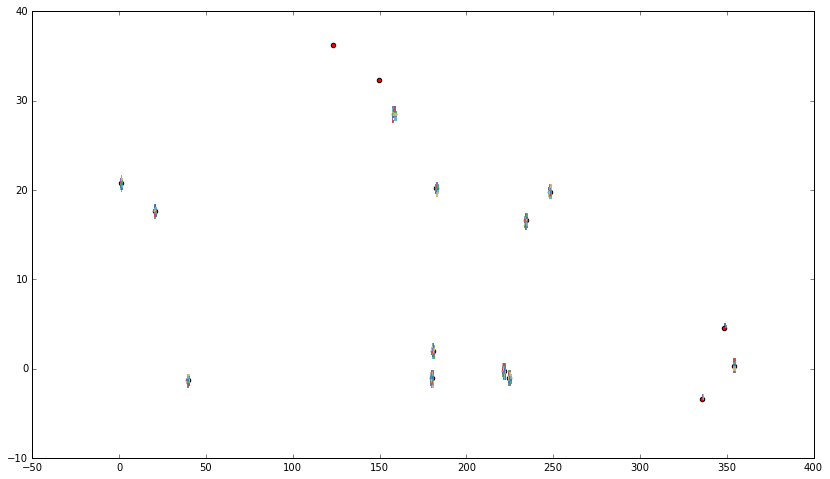

In [13]:
host_bricks_3 = find_host_bricks(paperhosts, bricksdr3)

for brick in host_bricks_3:
    x = [brick['RA1'], brick['RA2'], brick['RA2'], brick['RA1'], brick['RA1']]
    y = [brick['DEC1'], brick['DEC1'], brick['DEC2'], brick['DEC2'], brick['DEC1']]
    plt.plot(x, y)
    
plt.scatter(paperhostscs.ra.deg, paperhostscs.dec.deg, c='r')

len(host_bricks_3)

71

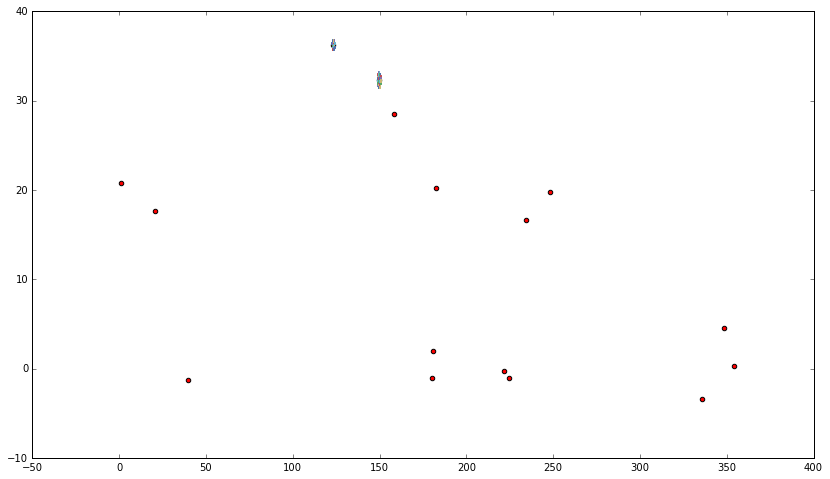

In [14]:
host_bricks_4 = find_host_bricks(paperhosts, bricksdr4)

for brick in host_bricks_4:
    x = [brick['RA1'], brick['RA2'], brick['RA2'], brick['RA1'], brick['RA1']]
    y = [brick['DEC1'], brick['DEC1'], brick['DEC2'], brick['DEC2'], brick['DEC1']]
    plt.plot(x, y)
    
plt.scatter(paperhostscs.ra.deg, paperhostscs.dec.deg, c='r')

len(host_bricks_4)

# Do the downloads 

In [35]:
def do_downloads(bricks, drnum):
    for brick in tqdm.tqdm_notebook(bricks,desc='bricks'):
        url = decals.brickname_to_catalog_url(brick['brickname'], int(drnum))
        fnout = 'decals_dr'+str(drnum)+'/catalogs/tractor-{}.fits'.format(brick['brickname'])

        if os.path.isfile(fnout):
            print(fnout, 'exists, skipping')
        else:
            print('Downloading', fnout)
            savedfn = data.download_file(url)
            shutil.move(savedfn, fnout)

In [36]:
do_downloads(host_bricks_3, 3)

decals_dr3/catalogs/tractor-0003p202.fits exists, skipping
decals_dr3/catalogs/tractor-0004p205.fits exists, skipping
decals_dr3/catalogs/tractor-0004p207.fits exists, skipping
decals_dr3/catalogs/tractor-0004p210.fits exists, skipping
decals_dr3/catalogs/tractor-0004p212.fits exists, skipping
decals_dr3/catalogs/tractor-0006p202.fits exists, skipping
decals_dr3/catalogs/tractor-0006p205.fits exists, skipping
decals_dr3/catalogs/tractor-0006p207.fits exists, skipping
decals_dr3/catalogs/tractor-0006p210.fits exists, skipping
decals_dr3/catalogs/tractor-0006p212.fits exists, skipping
decals_dr3/catalogs/tractor-0009p200.fits exists, skipping
decals_dr3/catalogs/tractor-0009p202.fits exists, skipping
decals_dr3/catalogs/tractor-0009p205.fits exists, skipping
decals_dr3/catalogs/tractor-0009p207.fits exists, skipping
decals_dr3/catalogs/tractor-0009p210.fits exists, skipping
decals_dr3/catalogs/tractor-0009p212.fits exists, skipping
decals_dr3/catalogs/tractor-0009p215.fits exists, skippi

301/|/ 67%|| 301/446 [00:14<00:07, 20.25it/s]osmo/data/legacysurvey//dr3/tractor/224/tractor-2243m012.fits [Done]


decals_dr3/catalogs/tractor-2473p195.fits exists, skipping
decals_dr3/catalogs/tractor-2474p197.fits exists, skipping
decals_dr3/catalogs/tractor-2474p202.fits exists, skipping
decals_dr3/catalogs/tractor-2475p192.fits exists, skipping
decals_dr3/catalogs/tractor-2475p200.fits exists, skipping
decals_dr3/catalogs/tractor-2476p195.fits exists, skipping
decals_dr3/catalogs/tractor-2476p202.fits exists, skipping
decals_dr3/catalogs/tractor-2477p192.fits exists, skipping
decals_dr3/catalogs/tractor-2477p197.fits exists, skipping
decals_dr3/catalogs/tractor-2478p195.fits exists, skipping
decals_dr3/catalogs/tractor-2478p200.fits exists, skipping
decals_dr3/catalogs/tractor-2478p205.fits exists, skipping
decals_dr3/catalogs/tractor-2479p197.fits exists, skipping
decals_dr3/catalogs/tractor-2479p202.fits exists, skipping
decals_dr3/catalogs/tractor-2480p192.fits exists, skipping
decals_dr3/catalogs/tractor-2480p200.fits exists, skipping
decals_dr3/catalogs/tractor-2481p195.fits exists, skippi

In [37]:
do_downloads(host_bricks_4, 4)

decals_dr4/catalogs/tractor-1224p365.fits exists, skipping
decals_dr4/catalogs/tractor-1225p360.fits exists, skipping
decals_dr4/catalogs/tractor-1226p362.fits exists, skipping
decals_dr4/catalogs/tractor-1227p357.fits exists, skipping
decals_dr4/catalogs/tractor-1227p365.fits exists, skipping
decals_dr4/catalogs/tractor-1228p360.fits exists, skipping
decals_dr4/catalogs/tractor-1228p367.fits exists, skipping
decals_dr4/catalogs/tractor-1229p362.fits exists, skipping
decals_dr4/catalogs/tractor-1230p357.fits exists, skipping
decals_dr4/catalogs/tractor-1230p365.fits exists, skipping
decals_dr4/catalogs/tractor-1231p360.fits exists, skipping
decals_dr4/catalogs/tractor-1231p367.fits exists, skipping
decals_dr4/catalogs/tractor-1232p362.fits exists, skipping
decals_dr4/catalogs/tractor-1233p357.fits exists, skipping
decals_dr4/catalogs/tractor-1233p365.fits exists, skipping
decals_dr4/catalogs/tractor-1234p360.fits exists, skipping
decals_dr4/catalogs/tractor-1234p367.fits exists, skippi